In [ ]:
"""
Anh Huynh
Francisco Rivera 
Aster Lee
Andrew Bae
Ian Escalante
Carlos Bordallo
Joshua Hicks

Github: https://csulb.instructure.com/courses/32109/modules/items/1833633
"""


'\nAnh Huynh\nFrancisco Rivera \nAster Lee\nAndrew Bae\n<other names>\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

data = pd.read_csv('/content/drive/My Drive/456FinalProject/AirQualityUCIv2.csv', na_values='-200')

Box Plot

Text(0.5, 0.98, 'Nitrous Oxide concentrations (ppb) by hourly times')

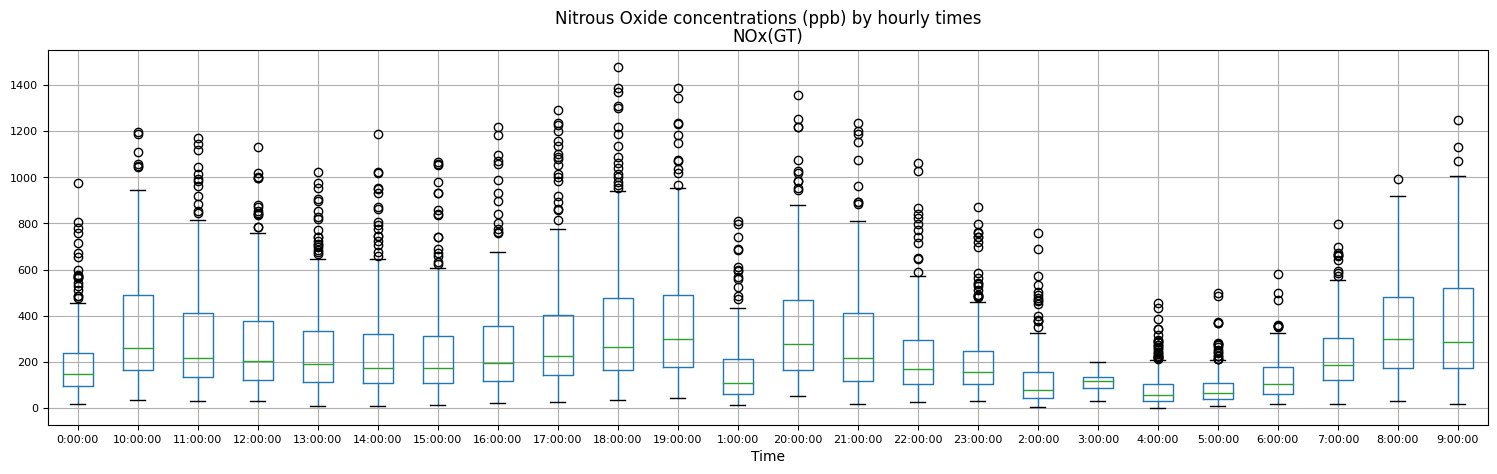

In [ ]:
nox_by_time = data.boxplot(column="NOx(GT)", by="Time", figsize=(18, 5), fontsize=8)
nox_by_time.get_figure().suptitle("Nitrous Oxide concentrations (ppb) by hourly times")

Histogram

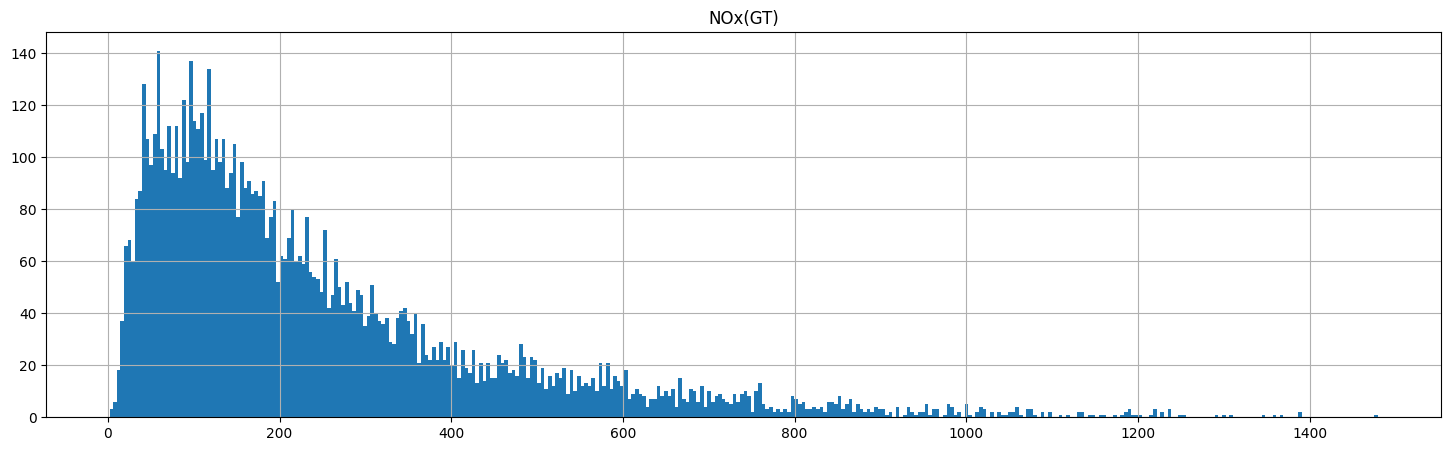

In [ ]:
# x = concentration of NOx(GT)
# y = amount of data sets 
nox_hist = data.hist(column="NOx(GT)", figsize=(18, 5), bins=350)

Line plot

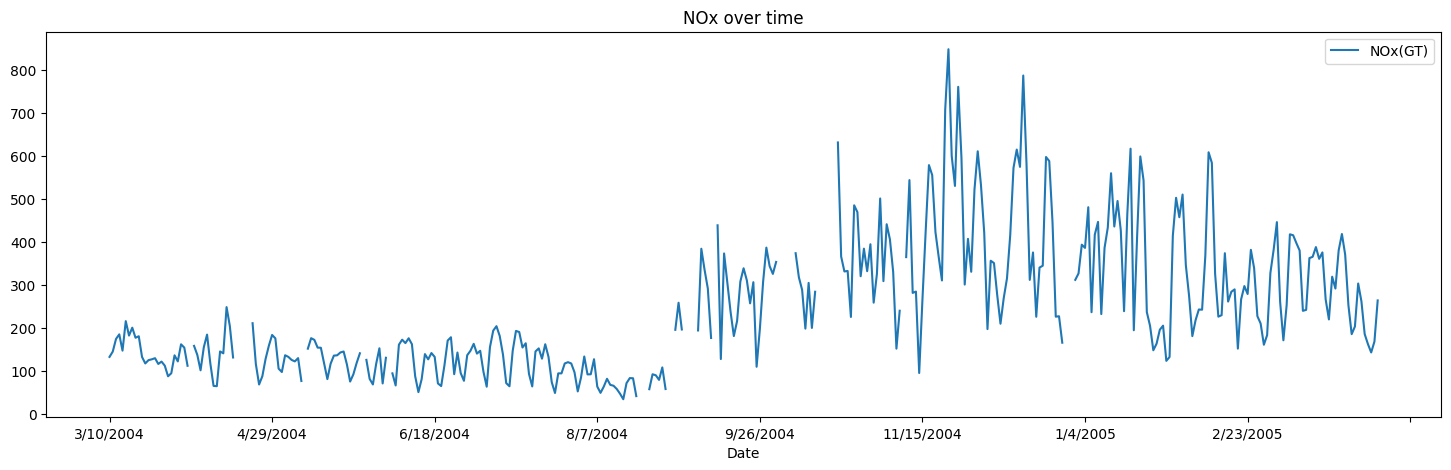

In [ ]:
nox_dated = data.groupby("Date", dropna=True)["NOx(GT)"].mean()
nox_dated = pd.DataFrame(nox_dated).sort_values(by="Date", key=lambda series: series.apply(lambda x: datetime.strptime(x, '%m/%d/%Y')))
nox_line = nox_dated.plot(title="NOx over time", figsize=(18, 5))

Correlation Matrix (NOx(GT))



In [ ]:
correlation_matrix = data.corr(numeric_only = True)['NOx(GT)']
print(correlation_matrix)

CO(GT)           0.795028
PT08.S1(CO)      0.713654
NMHC(GT)         0.812685
C6H6(GT)         0.718839
PT08.S2(NMHC)    0.704435
NOx(GT)          1.000000
PT08.S3(NOx)    -0.655707
NO2(GT)          0.763111
PT08.S4(NO2)     0.233731
PT08.S5(O3)      0.787046
T               -0.269683
RH               0.221032
AH              -0.149323
Name: NOx(GT), dtype: float64


PCA

Column Titles: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Time_seconds']


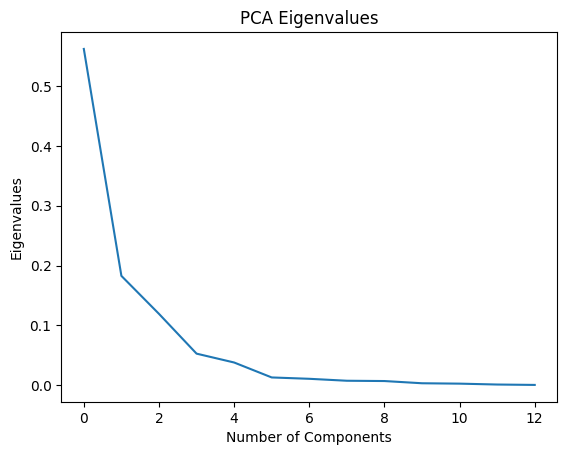

Number of Components: 3
PCA Explained Variance: [0.56188861 0.18267811 0.11921314]


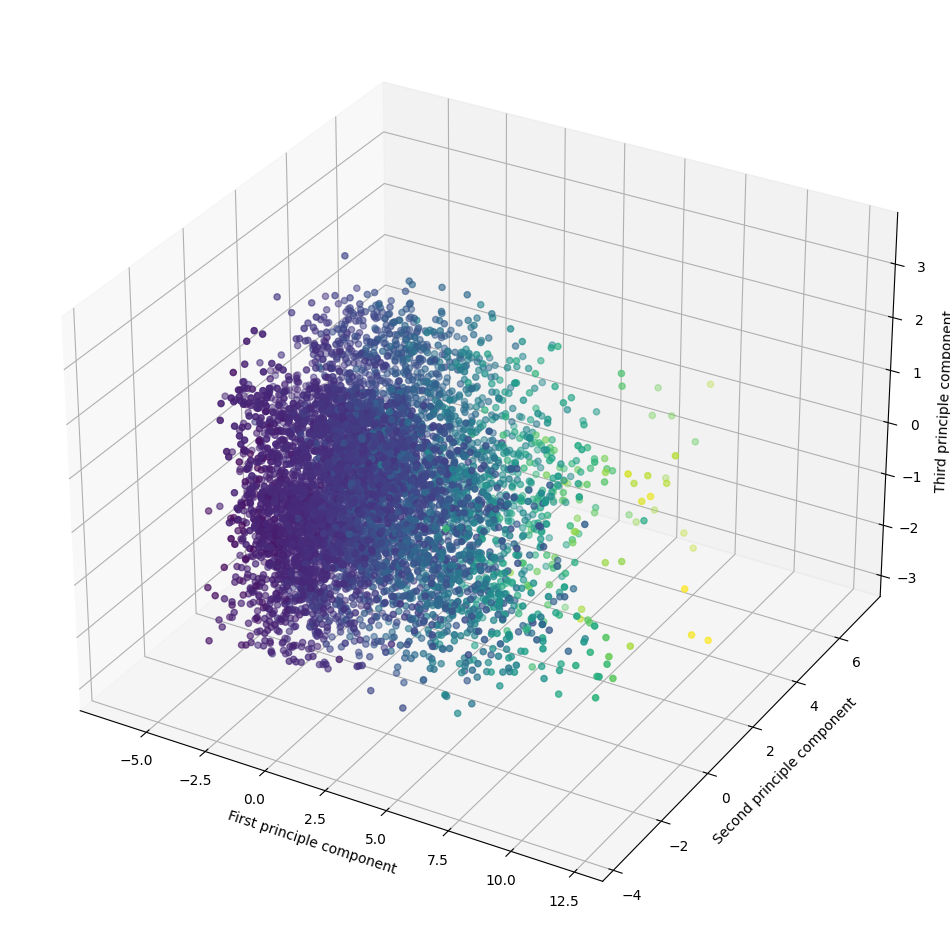

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


#turns data into a dataframe
#data2 = data.drop('NOx(GT)', axis=1)
df = pd.DataFrame(data)
#df = df.iloc[:, 2:15]
df = df.iloc[:, 1:15]

#included time to data set(Not Sure if this should be added)
df['Time_seconds'] = pd.to_timedelta(df['Time']).dt.total_seconds()
df = df.drop(columns=['Time'])

#Replacing NaN values(Required since PCA does not deal with missing values)
#imputer = SimpleImputer(strategy='mean') #NOT GOOD TOO GENERAL
#imputer = KNNImputer(n_neighbors=10) #Better
#MICE Imputer
imputer = IterativeImputer(max_iter=1000) #Best

df = pd.DataFrame(imputer.fit_transform(df), columns = imputer.get_feature_names_out())
X = df.drop('NOx(GT)', axis=1)
y = df['NOx(GT)']

#Split Data into Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Column Titles: {X_train.columns.tolist()}')
#print(df.loc[34])

#normalizes training and testing data
scaler = StandardScaler()
scaler.fit(X_train)
scaled_data = scaler.transform(X_train)
test_scaled_data = scaler.transform(X_test)

#print(scaled_data)

#Conducting PCA (Not on Target Values)
pca = PCA(n_components = 13)
#pca = PCA(.99) #setting the desired amount of variance to be retained
pca.fit(scaled_data)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.title('PCA Eigenvalues')
plt.show()

#Conducting PCA (Not on Target Values)
pca = PCA(n_components = 3)
#pca = PCA(.99) #setting the desired amount of variance to be retained
pca.fit(scaled_data)

print(f'Number of Components: {pca.n_components_}')
X_pca = pca.transform(scaled_data)
X_test_pca = pca.transform(test_scaled_data)
#displays the shape of the array
#print(flush='PCA Shape: {X_pca.shape}')
#print(X_pca)
print(f'PCA Explained Variance: {pca.explained_variance_ratio_}')

#Visual Representation of PCA with target N0x (Not the Full Representation of the PCA dataset)
#plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(12,16))
fig = fig.add_subplot(111, projection='3d')
fig.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c = y_train)

#plt.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c = y_train)
fig.set_xlabel('First principle component')
fig.set_ylabel('Second principle component')
fig.set_zlabel('Third principle component')
plt.show()

K-Folds Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

#Choose Model Type(Linear Regression)
model = LinearRegression()
model.fit(X_pca, y_train)

#Use K-Folds Cross Validation to score how accurate the model is(r2)
scores = cross_val_score(model, X_pca, y_train, cv = 10, scoring='r2')
print(f'r2 scores: {scores}')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

#Make Prediction Using Testing Data
prediction = model.predict(X_test_pca)
MSE = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
print(f'Mean Squared Error: {MSE}')
print(f'r2 Score: {r2}')

r2 scores: [0.7751196  0.77644785 0.79991882 0.80920981 0.786872   0.79975786
 0.815867   0.77849444 0.78075171 0.78263396]
Accuracy: 0.79 (+/- 0.03)
Mean Squared Error: 9297.515357981762
r2 Score: 0.7875187623789739


Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

#Instantiating the different models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'Bayesian Ridge Regression': BayesianRidge(),
    'Huber Regression': HuberRegressor()
}

#Establishing which params we are going to perform hyperparameter Tuning
params = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'Lasso Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'Elastic Net Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'Bayesian Ridge Regression': {'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]},
    'Huber Regression': {'epsilon': [1.25, 1.5, 1.75], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
}

#specifying the metric to use for evaluating the performance of the models
#scoring_value = make_scorer(mean_squared_error, greater_is_better=False)

#Goes through each model and tests which param produces the most accurate score
for name, model in models.items():
    print(f'Tuning hyperparameters for {name}')
    grid_search = GridSearchCV(model, params[name], cv=5, return_train_score=False)
    grid_search.fit(X_pca, y_train)
    print(f'Best hyperparameters: {grid_search.best_params_}')
    print(f'Train MSE: {mean_squared_error(y_train, grid_search.predict(X_pca))}')
    print(f'Test MSE: {mean_squared_error(y_test, grid_search.predict(X_test_pca))}')
    print(f'Train r2 score: {r2_score(y_train, grid_search.predict(X_pca))}')
    print(f'Test r2 score: {r2_score(y_test, grid_search.predict(X_test_pca))}')
    print(f'Best Score: {grid_search.best_score_} \n')


Tuning hyperparameters for Linear Regression
Best hyperparameters: {}
Train MSE: 8875.23304885804
Test MSE: 9297.515357981762
Train r2 score: 0.7915325121088257
Test r2 score: 0.7875187623789739
Best Score: 0.7908017712918148 

Tuning hyperparameters for Ridge Regression
Best hyperparameters: {'alpha': 10}
Train MSE: 8875.238363377257
Test MSE: 9297.617142051171
Train r2 score: 0.7915323872777972
Test r2 score: 0.7875164362515941
Best Score: 0.7908018403052041 

Tuning hyperparameters for Lasso Regression
Best hyperparameters: {'alpha': 0.01}
Train MSE: 8875.23316918234
Test MSE: 9297.562399782104
Train r2 score: 0.791532509282567
Test r2 score: 0.7875176873068098
Best Score: 0.7908017760109847 

Tuning hyperparameters for Elastic Net Regression
Best hyperparameters: {'alpha': 0.001, 'l1_ratio': 0.1}
Train MSE: 8875.234903766479
Test MSE: 9297.57455966091
Train r2 score: 0.7915324685394795
Test r2 score: 0.7875174094104043
Best Score: 0.7908018522771506 

Tuning hyperparameters for Bay